Import Modules

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

Hyperparameters

In [89]:
dataset_path = '~/datasets'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

# Model parameters
input_channels = 1
latent_dim = 20


Define the Encoder

In [91]:
# Devine the Encoder
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: (64, 7, 7)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_log_var = nn.Linear(64 * 7 * 7, latent_dim)

        self.relu = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

Define the Decoder

In [93]:
#Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 14, 14)
        self.deconv2 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  # Output: (1, 28, 28)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)  # Reshape to spatial dimensions
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # Sigmoid to constrain outputs between 0 and 1
        return x

Define VAE Architecture 

In [95]:
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(DEVICE)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var


Loss Function

In [97]:
def loss_function(reconstructed, original, mean, log_var):
    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

Train on MNIST

In [149]:
kwargs = {'num_workers': 1, 'pin_memory': True} 

# Define transformations
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any other transformations as needed, e.g., normalization
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=False)

# Filter for images labeled 0
filtered_images = []
filtered_labels = []
for image, label in train_dataset:
    if label == 0:
        filtered_images.append(image)
        filtered_labels.append(label)

# Create a new TensorDataset with filtered data
filtered_dataset = TensorDataset(torch.stack(filtered_images), torch.tensor(filtered_labels))

# Create a new DataLoader
train_loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

test_dataset  = datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=False)

# Filter test dataset based on digit label
test_dataset_1 = [(x, y) for x, y in test_dataset if y == 1]
#test_dataset_2 = [(x, y) for x, y in test_dataset if y == 2]
#test_dataset_3 = [(x, y) for x, y in test_dataset if y == 3]
#test_dataset_4 = [(x, y) for x, y in test_dataset if y == 4]
#test_dataset_5 = [(x, y) for x, y in test_dataset if y == 5]
#test_dataset_6 = [(x, y) for x, y in test_dataset if y == 6]
#test_dataset_7 = [(x, y) for x, y in test_dataset if y == 7]
#test_dataset_8 = [(x, y) for x, y in test_dataset if y == 8]
#test_dataset_9 = [(x, y) for x, y in test_dataset if y == 9]
#test_dataset_0 = [(x, y) for x, y in test_dataset if y == 0]
test_loader  = DataLoader(dataset=test_dataset_1,  batch_size=batch_size, shuffle=False,  **kwargs) # Change value for dataset to generate different numbers

# Define model
vae = VAE(input_channels, latent_dim).to(DEVICE)

# Optimizer
optimizer = Adam(vae.parameters(), lr=0.001)

# Training loop
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(torch.float32)
        images = images.to(DEVICE)

        optimizer.zero_grad()
        reconstructed, mean, log_var = vae(images)
        loss = loss_function(reconstructed, images, mean, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(mnist_data)}")


Epoch 1, Loss: 28.508450846354165
Epoch 2, Loss: 17.0402544921875
Epoch 3, Loss: 13.681609342447917
Epoch 4, Loss: 12.483940950520834
Epoch 5, Loss: 11.973619921875
Epoch 6, Loss: 11.644086197916666
Epoch 7, Loss: 11.430029166666667
Epoch 8, Loss: 11.260302734375
Epoch 9, Loss: 11.127304703776042
Epoch 10, Loss: 11.0205494140625


Visualize Reconstruction

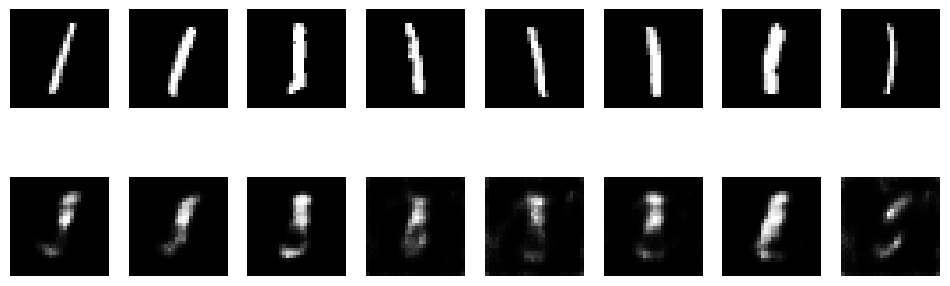

In [151]:
vae.eval()
test_images, _ = next(iter(test_loader))
test_images = test_images[:8].to(DEVICE)
reconstructed, _, _ = vae(test_images)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i in range(8):
    # Original images
    axes[0, i].imshow(test_images[i].cpu().numpy().reshape(28,28), cmap='gray')
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1, i].imshow(reconstructed[i].detach().cpu().numpy().reshape(28,28), cmap='gray')
    axes[1, i].axis('off')
plt.show()


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())
    
def show_training_image(dataset, id):
    # Reshape the tensor to (batch_size, 28, 28)
    image_tensor = dataset[id][0]
    # Reshape the tensor to (28, 28) if it's flattened
    image_tensor = image_tensor.view(28, 28)

    # Plot the image
    plt.figure()
    plt.imshow(image_tensor.cpu().numpy(), cmap='gray')
    plt.title(f"Training Image at Index {id}")
    plt.axis('off')
    plt.show()

In [ ]:
show_image(x_hat, idx=20)